<a href="https://colab.research.google.com/github/noani190/transfer-learning/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

In [1]:
!pip install --quiet evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platf

In [2]:
import io
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from huggingface_hub import notebook_login

from datasets import load_dataset, DatasetDict

from transformers import AutoImageProcessor, ViTForImageClassification

from transformers import Trainer, TrainingArguments

import evaluate

In [3]:
notebook_login()

Loading a collection of 37 different cat and dog breed images (Oxford-IIIT Pets Dataset) using Hugging Face Datasets library.
Dataset features:
* path: a path to the file
* label: the breed of the animal
* dog: indicates if the animal is a dog or not
* image: the raw image data stored as bytes, which can be converted into formats like PIL Image for further processing.

In [4]:
dataset = load_dataset('pcuenq/oxford-pets')
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/565 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

(…)-00000-of-00001-ecc2afb43dedd5e0.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7390 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 7390
    })
})

In [5]:
labels = dataset['train'].unique('label')
print(len(labels),labels)

37 ['Siamese', 'Birman', 'shiba inu', 'staffordshire bull terrier', 'basset hound', 'Bombay', 'japanese chin', 'chihuahua', 'german shorthaired', 'pomeranian', 'beagle', 'english cocker spaniel', 'american pit bull terrier', 'Ragdoll', 'Persian', 'Egyptian Mau', 'miniature pinscher', 'Sphynx', 'Maine Coon', 'keeshond', 'yorkshire terrier', 'havanese', 'leonberger', 'wheaten terrier', 'american bulldog', 'english setter', 'boxer', 'newfoundland', 'Bengal', 'samoyed', 'British Shorthair', 'great pyrenees', 'Abyssinian', 'pug', 'saint bernard', 'Russian Blue', 'scottish terrier']


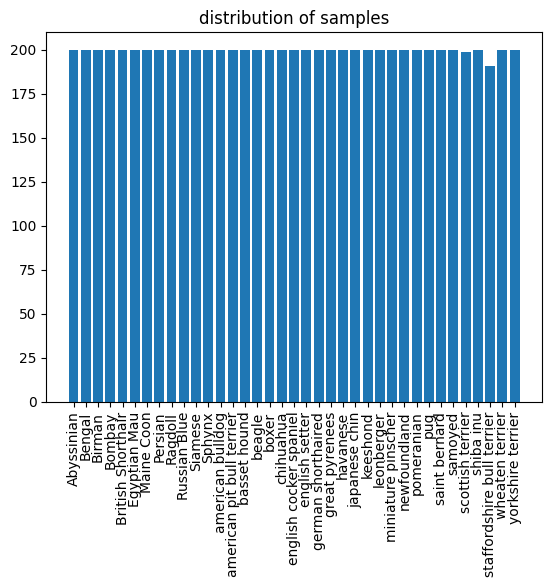

In [6]:
sample_count = list(zip(*np.unique(dataset['train']['label'], return_counts=True)))
sample_names, sample_counts = np.unique(dataset['train']['label'], return_counts=True)
plt.bar(sample_names, sample_counts)
plt.xticks(rotation=90)
plt.title('distribution of samples')
plt.show()

Visualize some of the data:

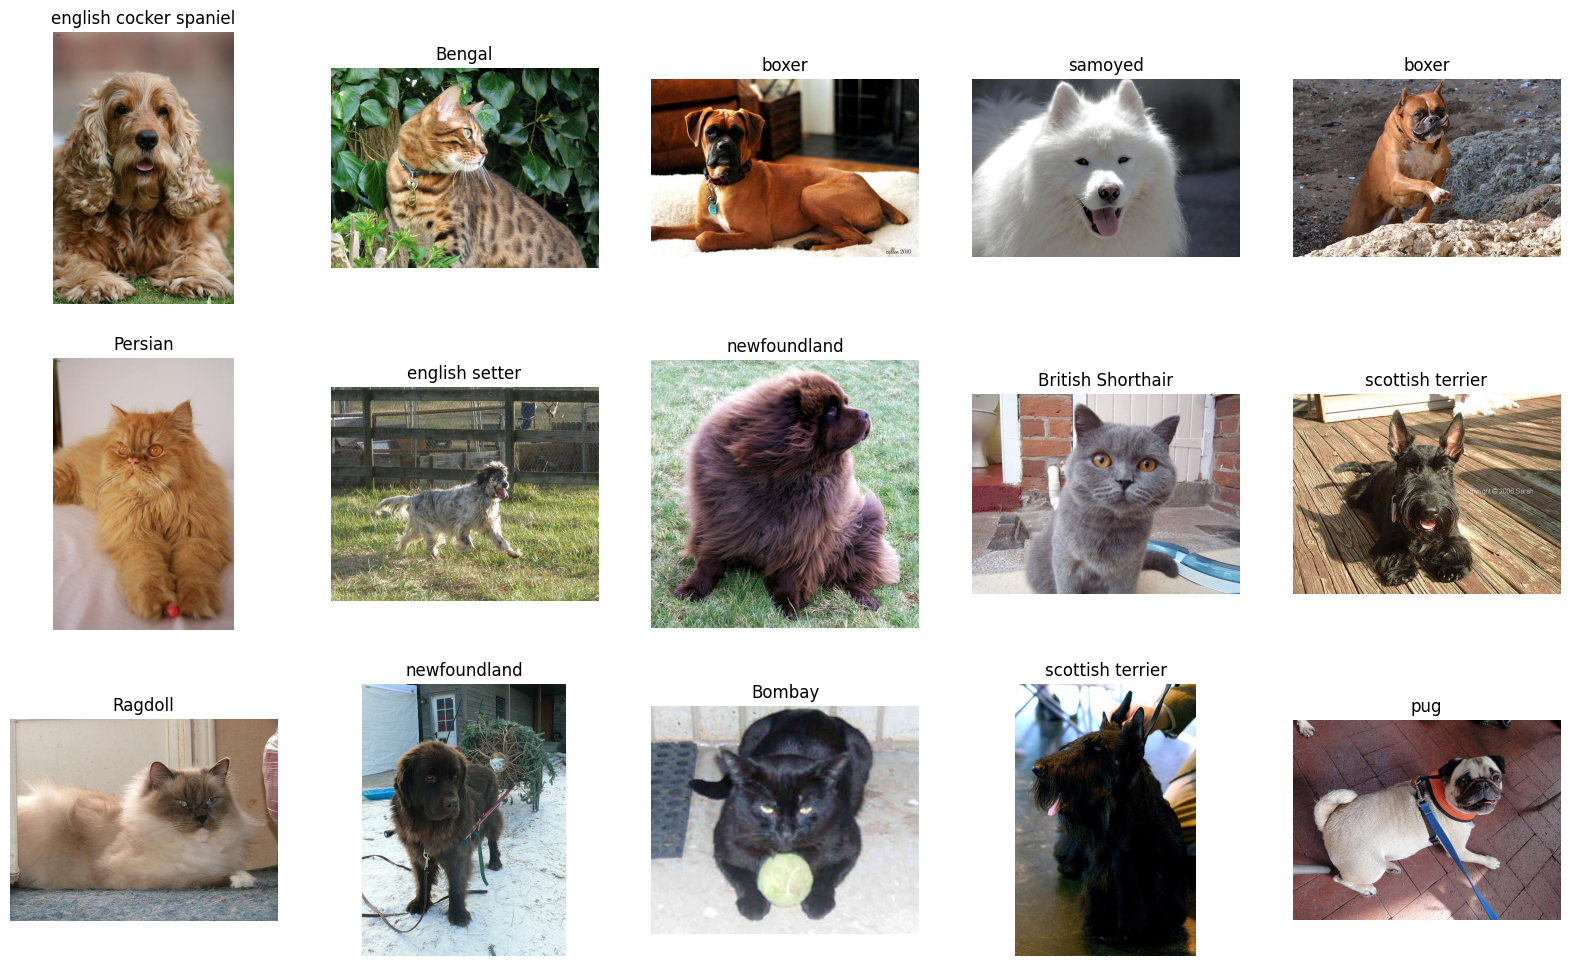

In [7]:
def show_samples(ds, rows, cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4, rows*4))
    # plotting
    for i in range(rows*cols):
        img_bytes = samples[i]['image']['bytes']
        img = Image.open(io.BytesIO(img_bytes))
        label = samples[i]['label']
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_samples(dataset['train'], rows=3, cols=5)

## Spliting the dataset

In [8]:
split_dataset = dataset['train'].train_test_split(test_size=0.2) # 80% train, 20% evaluation
eval_dataset = split_dataset['test'].train_test_split(test_size=0.5) # 50% validation, 50% test

# recombining the splits using a DatasetDict

our_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': eval_dataset['train'],
    'test': eval_dataset['test']
})

our_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 5912
    })
    validation: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
    test: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 739
    })
})

In [9]:
# map string-value labeles to integers
label2id = {c:idx for idx,c in enumerate(labels)}
id2label = {idx:c for idx,c in enumerate(labels)}

## Preprocessing

The pre-trained model I'll be using is 'google/vit-base-patch16-224'.
To create a generic pre-processing function, I'll apply the transformations that had been defined in the model configuration.

### About the model

The model was pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224, and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at resolution 224x224. More information about the model can be found here: https://huggingface.co/google/vit-base-patch16-224

In [10]:
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

### Pre-processing sub-steps

I will pass the batches of data through a preprocessing function, that will apply the following transformations:

* Converting all images into RGB: some images might be grayscale or transparent.
* Applying image transforms: we pass the images through the processor to process, and convert them into PyTorch format.
* Converting the string labels to integers: using the label2id map.

In [11]:
def transforms(batch):
    batch['image'] = [Image.open(io.BytesIO(x['bytes'])).convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'], return_tensors='pt')
    inputs['labels'] = [label2id[y] for y in batch['label']]
    return inputs

In [12]:
processed_dataset = our_dataset.with_transform(transforms)

Note: the processed dataset contains 'pixel_values' and 'labels' keys

In [13]:
processed_dataset['train'][0]['pixel_values'].shape

torch.Size([3, 224, 224])

In [14]:
processed_dataset['train'][0]['labels']

18

### Data Formatting (Collation)

Batching the data in the correct format: for pixel_values, the input shape for the model should be (batch, channels, height, width) and for labels, the shape should be (batch,)

In [15]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Setting Evaluation Matrix

In [16]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

## Loading the Model

When loading the model, I need to update the final classification layer, to output predictions equal to the number of labels in our dataset.

In [17]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True # compensate for the change in number of parameters in the classification layer.
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([37, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Model architecture

In [18]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

* freeze all the parameters except for the new classifier layer by setting requires_grad to False for each layer's parameters since we only train the final classifier layer

In [19]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

* count total & trained parameters:

In [20]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,827,109 | trainable_params = 28,453


* The trainable parameters account for the final (classification) layer which has the shape of [37, 768] (37*768 = 28416) plus 37 bias terms which gives 28453.

## Training

In [21]:
training_args = TrainingArguments(
    output_dir="./training_output/vit-base-oxford-iiit-pets",
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=5,
    # learning_rate=3e-4,
    save_total_limit=10,  # 2
    remove_unused_columns=False,
    # push_to_hub=False,  # False by default
    report_to="none",
    load_best_model_at_end=True,
)

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    processing_class=processor
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,2.124600,1.606457,0.814614


Epoch,Training Loss,Validation Loss,Accuracy
1,2.124600,1.606457,0.814614


In [1]:
trainer.evaluate(processed_dataset['test'])

NameError: name 'trainer' is not defined